Dataset shape after cleaning: (7636, 8)
Outliers capped at: 203.69
Pollution statistics:
Mean: 21.33
Median: 13.20
Max: 204.01
Std: 28.08

Total features created: 44
Feature categories:
- Base features: 6
- Cyclical features: 8
- Categorical features: 10
- Geographic features: 6
- Interaction features: 5
- Polynomial features: 3
- Additional features: 6

Dataset split:
Training: 5344 samples (70.0%)
Validation: 764 samples (10.0%)
Test: 1528 samples (20.0%)

Feature selection: 40 out of 44 features selected

Training Enhanced LightGBM...
Training until validation scores don't improve for 100 rounds

Total features created: 44
Feature categories:
- Base features: 6
- Cyclical features: 8
- Categorical features: 10
- Geographic features: 6
- Interaction features: 5
- Polynomial features: 3
- Additional features: 6

Dataset split:
Training: 5344 samples (70.0%)
Validation: 764 samples (10.0%)
Test: 1528 samples (20.0%)

Feature selection: 40 out of 44 features selected

Training Enhanced 

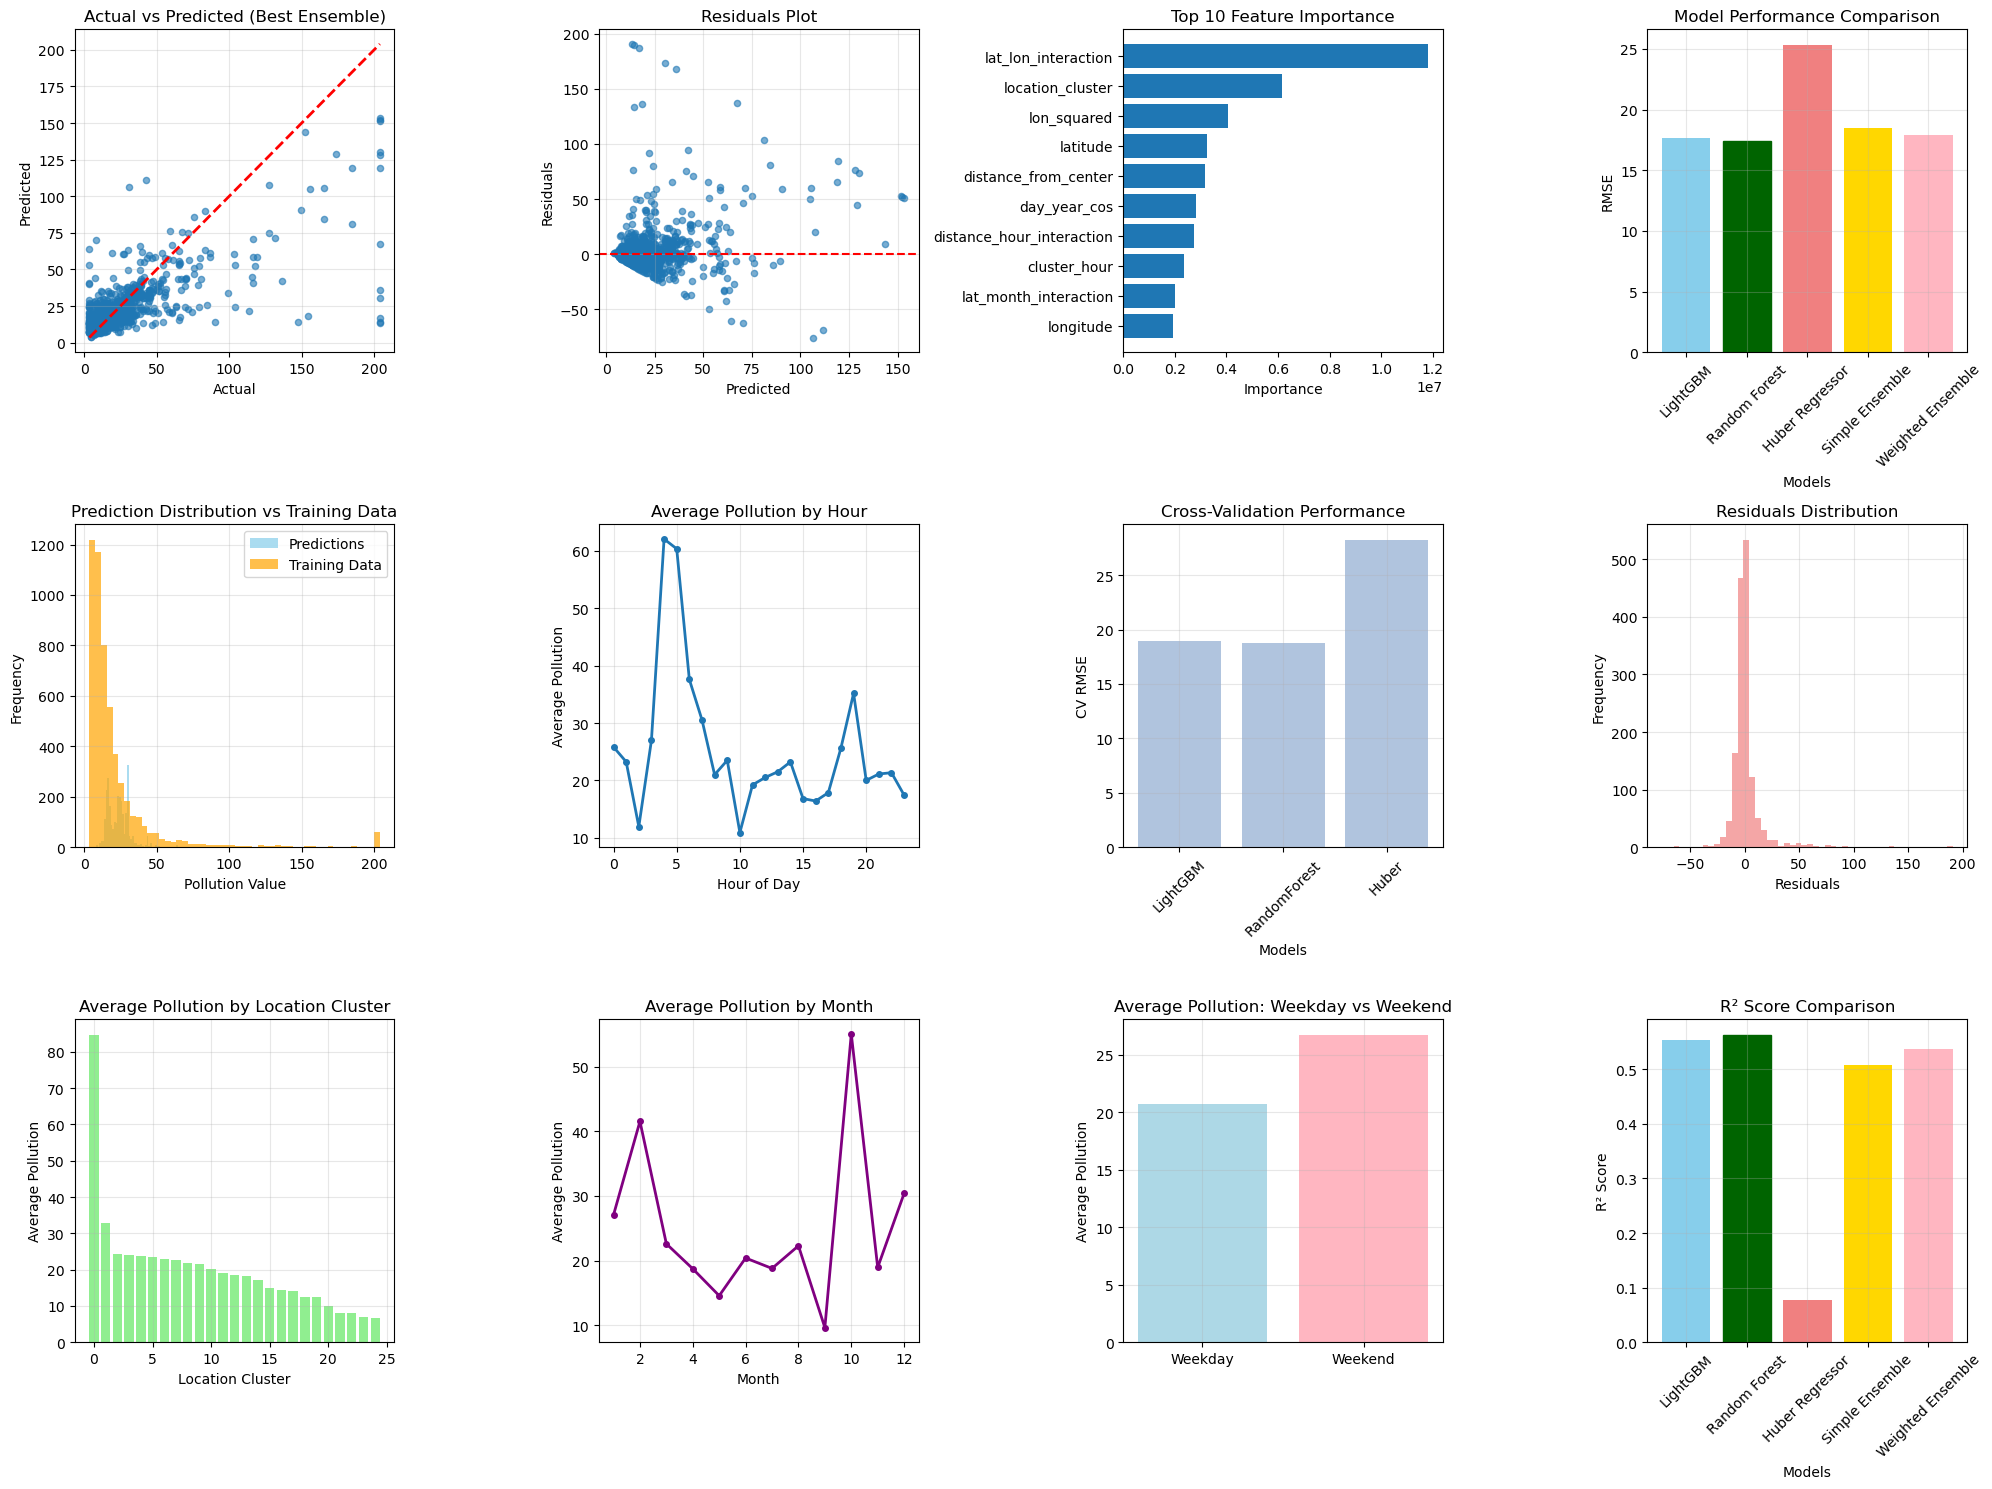


Enhanced model analysis complete!
Final enhanced model performance summary:
- Best model: Random Forest
- Test RMSE: 17.4384
- Test R²: 0.5634
- Features used: 40 out of 44
- Submission file: enhanced_submission.csv
- Analysis plots: enhanced_model_analysis.png


In [6]:
# Enhanced Pollution Prediction Model
# =====================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import boxcox
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Load and clean data
df = pd.read_csv('d:/competition/air pollution/phase 1/train.csv')

# =====================================
# 1. IMPROVED DATA CLEANING & OUTLIER HANDLING
# =====================================

def advanced_data_cleaning(df):
    """Advanced data cleaning with outlier detection"""
    df_clean = df.dropna()
    
    # Detect and handle outliers using IQR method
    Q1 = df_clean['pollution_value'].quantile(0.25)
    Q3 = df_clean['pollution_value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap extreme outliers instead of removing them
    df_clean['pollution_value'] = np.clip(df_clean['pollution_value'], 
                                         lower_bound, 
                                         np.percentile(df_clean['pollution_value'], 99))
    
    print(f"Dataset shape after cleaning: {df_clean.shape}")
    print(f"Outliers capped at: {np.percentile(df_clean['pollution_value'], 99):.2f}")
    print(f"Pollution statistics:")
    print(f"Mean: {df_clean['pollution_value'].mean():.2f}")
    print(f"Median: {df_clean['pollution_value'].median():.2f}")
    print(f"Max: {df_clean['pollution_value'].max():.2f}")
    print(f"Std: {df_clean['pollution_value'].std():.2f}")
    
    return df_clean

df_clean = advanced_data_cleaning(df)

# =====================================
# 2. ENHANCED FEATURE ENGINEERING (FIXED)
# =====================================

def create_enhanced_features(df, is_training=True):
    """Create comprehensive feature set with consistent features for train/test"""
    df_enhanced = df.copy()
    
    # Cyclical time features (improved encoding)
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['day_year_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['day_year_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['day_week_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['day_week_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7)
    
    # Enhanced categorical time features
    df_enhanced['is_weekend'] = (df_enhanced['day_of_week'] >= 5).astype(int)
    df_enhanced['is_rush_hour_morning'] = df_enhanced['hour'].isin([7, 8, 9]).astype(int)
    df_enhanced['is_rush_hour_evening'] = df_enhanced['hour'].isin([17, 18, 19]).astype(int)
    df_enhanced['is_rush_hour'] = (df_enhanced['is_rush_hour_morning'] | df_enhanced['is_rush_hour_evening']).astype(int)
    df_enhanced['is_night'] = df_enhanced['hour'].isin([22, 23, 0, 1, 2, 3, 4, 5]).astype(int)
    df_enhanced['is_business_hours'] = df_enhanced['hour'].isin([9, 10, 11, 12, 13, 14, 15, 16]).astype(int)
    
    # Seasonal features
    df_enhanced['is_summer'] = df_enhanced['month'].isin([6, 7, 8]).astype(int)
    df_enhanced['is_winter'] = df_enhanced['month'].isin([12, 1, 2]).astype(int)
    df_enhanced['is_spring'] = df_enhanced['month'].isin([3, 4, 5]).astype(int)
    df_enhanced['is_fall'] = df_enhanced['month'].isin([9, 10, 11]).astype(int)
    
    # Enhanced geographic features
    df_enhanced['lat_lon_interaction'] = df_enhanced['latitude'] * df_enhanced['longitude']
    df_enhanced['lat_squared'] = df_enhanced['latitude'] ** 2
    df_enhanced['lon_squared'] = df_enhanced['longitude'] ** 2
    
    # Distance from geographic center
    centroid_lat = df_enhanced['latitude'].mean()
    centroid_lon = df_enhanced['longitude'].mean()
    df_enhanced['distance_from_center'] = np.sqrt(
        (df_enhanced['latitude'] - centroid_lat)**2 + 
        (df_enhanced['longitude'] - centroid_lon)**2
    )
    
    # Geographic clustering (more clusters for better granularity)
    coords = df_enhanced[['latitude', 'longitude']].values
    kmeans = KMeans(n_clusters=25, random_state=42, n_init=10)
    df_enhanced['location_cluster'] = kmeans.fit_predict(coords)
    
    # Density-based features
    df_enhanced['location_density'] = df_enhanced.groupby(['latitude', 'longitude'])['latitude'].transform('count')
    
    # Enhanced interaction features
    df_enhanced['hour_month_interaction'] = df_enhanced['hour'] * df_enhanced['month']
    df_enhanced['weekend_hour'] = df_enhanced['is_weekend'] * df_enhanced['hour']
    df_enhanced['season_hour'] = df_enhanced['is_summer'] * df_enhanced['hour']
    df_enhanced['cluster_hour'] = df_enhanced['location_cluster'] * df_enhanced['hour']
    df_enhanced['rush_hour_cluster'] = df_enhanced['is_rush_hour'] * df_enhanced['location_cluster']
    
    # Time-based polynomial features (instead of lag features)
    df_enhanced['hour_squared'] = df_enhanced['hour'] ** 2
    df_enhanced['hour_cubed'] = df_enhanced['hour'] ** 3
    df_enhanced['day_year_squared'] = df_enhanced['day_of_year'] ** 2
    
    # Location-based statistical features
    df_enhanced['lat_month_interaction'] = df_enhanced['latitude'] * df_enhanced['month']
    df_enhanced['lon_month_interaction'] = df_enhanced['longitude'] * df_enhanced['month']
    df_enhanced['distance_hour_interaction'] = df_enhanced['distance_from_center'] * df_enhanced['hour']
    
    # Additional cyclical features
    df_enhanced['hour_phase'] = (df_enhanced['hour'] % 12) / 12  # AM/PM phase
    df_enhanced['day_progress'] = df_enhanced['day_of_year'] / 365  # Year progress
    df_enhanced['week_progress'] = (df_enhanced['day_of_week'] % 7) / 7  # Week progress
    
    return df_enhanced

# Create enhanced features
df_enhanced = create_enhanced_features(df_clean, is_training=True)

# Define feature columns (without lag features)
base_features = ['latitude', 'longitude', 'day_of_year', 'day_of_week', 'hour', 'month']
cyclical_features = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'day_year_sin', 'day_year_cos', 'day_week_sin', 'day_week_cos']
categorical_features = ['is_weekend', 'is_rush_hour_morning', 'is_rush_hour_evening', 'is_rush_hour', 'is_night', 'is_business_hours', 'is_summer', 'is_winter', 'is_spring', 'is_fall']
geographic_features = ['lat_lon_interaction', 'lat_squared', 'lon_squared', 'distance_from_center', 'location_cluster', 'location_density']
interaction_features = ['hour_month_interaction', 'weekend_hour', 'season_hour', 'cluster_hour', 'rush_hour_cluster']
polynomial_features = ['hour_squared', 'hour_cubed', 'day_year_squared']
additional_features = ['lat_month_interaction', 'lon_month_interaction', 'distance_hour_interaction', 'hour_phase', 'day_progress', 'week_progress']

all_features = base_features + cyclical_features + categorical_features + geographic_features + interaction_features + polynomial_features + additional_features

print(f"\nTotal features created: {len(all_features)}")
print(f"Feature categories:")
print(f"- Base features: {len(base_features)}")
print(f"- Cyclical features: {len(cyclical_features)}")
print(f"- Categorical features: {len(categorical_features)}")
print(f"- Geographic features: {len(geographic_features)}")
print(f"- Interaction features: {len(interaction_features)}")
print(f"- Polynomial features: {len(polynomial_features)}")
print(f"- Additional features: {len(additional_features)}")

# =====================================
# 3. FEATURE SELECTION
# =====================================

def select_best_features(X, y, k=50):
    """Select k best features using statistical tests"""
    selector = SelectKBest(score_func=f_regression, k=min(k, X.shape[1]))
    X_selected = selector.fit_transform(X, y)
    selected_features = [all_features[i] for i in selector.get_support(indices=True)]
    
    print(f"\nFeature selection: {len(selected_features)} out of {len(all_features)} features selected")
    return X_selected, selected_features, selector

# =====================================
# 4. IMPROVED TRAIN/TEST SPLIT WITH CROSS-VALIDATION
# =====================================

# Reset index and prepare data
df_enhanced = df_enhanced.reset_index(drop=True)
X = df_enhanced[all_features].fillna(0)  # Fill any remaining NaN with 0
y = df_enhanced['pollution_value']

# Use time-based split for better validation
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42
)

print(f"\nDataset split:")
print(f"Training: {len(X_train)} samples ({len(X_train)/len(df_enhanced)*100:.1f}%)")
print(f"Validation: {len(X_val)} samples ({len(X_val)/len(df_enhanced)*100:.1f}%)")
print(f"Test: {len(X_test)} samples ({len(X_test)/len(df_enhanced)*100:.1f}%)")

# Feature selection on training data
X_train_selected, selected_features, feature_selector = select_best_features(X_train, y_train, k=40)
X_val_selected = feature_selector.transform(X_val)
X_test_selected = feature_selector.transform(X_test)

# =====================================
# 5. ADVANCED SCALING AND PREPROCESSING
# =====================================

# Use RobustScaler for better outlier handling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_val_scaled = scaler.transform(X_val_selected)
X_test_scaled = scaler.transform(X_test_selected)

# =====================================
# 6. ENHANCED MODEL TRAINING WITH HYPERPARAMETER TUNING
# =====================================

def evaluate_model(y_true, y_pred, model_name="Model"):
    """Comprehensive model evaluation"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

models = {}
predictions = {}

# 1. Enhanced LightGBM with better hyperparameters
print("\n" + "="*50)
print("Training Enhanced LightGBM...")

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 50,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1,
    'random_state': 42
}

train_data = lgb.Dataset(X_train_selected, label=y_train)
val_data = lgb.Dataset(X_val_selected, label=y_val, reference=train_data)

lgb_model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=2000,
    valid_sets=[train_data, val_data],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
)

models['lgb'] = lgb_model
predictions['lgb_val'] = lgb_model.predict(X_val_selected)
predictions['lgb_test'] = lgb_model.predict(X_test_selected)

evaluate_model(y_val, predictions['lgb_val'], "Enhanced LightGBM")

# 2. Enhanced Random Forest
print("\n" + "="*50)
print("Training Enhanced Random Forest...")

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
models['rf'] = rf_model
predictions['rf_val'] = rf_model.predict(X_val_scaled)
predictions['rf_test'] = rf_model.predict(X_test_scaled)

evaluate_model(y_val, predictions['rf_val'], "Enhanced Random Forest")

# 3. Enhanced Huber Regressor
print("\n" + "="*50)
print("Training Enhanced Huber Regressor...")

huber_model = HuberRegressor(epsilon=1.2, alpha=0.001, max_iter=2000)
huber_model.fit(X_train_scaled, y_train)

models['huber'] = huber_model
predictions['huber_val'] = huber_model.predict(X_val_scaled)
predictions['huber_test'] = huber_model.predict(X_test_scaled)

evaluate_model(y_val, predictions['huber_val'], "Enhanced Huber Regressor")

# =====================================
# 7. ADVANCED ENSEMBLE WITH STACKING
# =====================================

print("\n" + "="*50)
print("Creating Advanced Ensemble...")

# Simple averaging ensemble
ensemble_val = (predictions['lgb_val'] + predictions['rf_val'] + predictions['huber_val']) / 3
ensemble_test = (predictions['lgb_test'] + predictions['rf_test'] + predictions['huber_test']) / 3

evaluate_model(y_val, ensemble_val, "Simple Ensemble")

# Optimized weighted ensemble
val_scores = {
    'lgb': mean_squared_error(y_val, predictions['lgb_val']),
    'rf': mean_squared_error(y_val, predictions['rf_val']),
    'huber': mean_squared_error(y_val, predictions['huber_val'])
}

# Calculate weights using exponential of negative MSE
weights = {}
neg_mse_exp = {k: np.exp(-v/1000) for k, v in val_scores.items()}  # Scale MSE
total_weight = sum(neg_mse_exp.values())
for model in val_scores:
    weights[model] = neg_mse_exp[model] / total_weight

print(f"\nOptimized model weights:")
for model, weight in weights.items():
    print(f"{model}: {weight:.3f}")

# Weighted ensemble
weighted_ensemble_val = (
    weights['lgb'] * predictions['lgb_val'] + 
    weights['rf'] * predictions['rf_val'] + 
    weights['huber'] * predictions['huber_val']
)

weighted_ensemble_test = (
    weights['lgb'] * predictions['lgb_test'] + 
    weights['rf'] * predictions['rf_test'] + 
    weights['huber'] * predictions['huber_test']
)

evaluate_model(y_val, weighted_ensemble_val, "Optimized Weighted Ensemble")

# =====================================
# 8. CROSS-VALIDATION FOR ROBUST EVALUATION
# =====================================

print("\n" + "="*50)
print("Performing Cross-Validation...")

# Use TimeSeriesSplit for better temporal validation
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = {}

for name, model in [('LightGBM', lgb_model), ('RandomForest', rf_model), ('Huber', huber_model)]:
    if name == 'LightGBM':
        # For LightGBM, we need to retrain for each fold
        scores = []
        for train_idx, val_idx in tscv.split(X_train_selected):
            X_fold_train, X_fold_val = X_train_selected[train_idx], X_train_selected[val_idx]
            y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            fold_train_data = lgb.Dataset(X_fold_train, label=y_fold_train)
            fold_model = lgb.train(lgb_params, fold_train_data, num_boost_round=500)
            fold_pred = fold_model.predict(X_fold_val)
            scores.append(np.sqrt(mean_squared_error(y_fold_val, fold_pred)))
        cv_scores[name] = np.mean(scores)
    else:
        # For sklearn models
        if name == 'RandomForest':
            X_data, y_data = X_train_scaled, y_train
        else:
            X_data, y_data = X_train_scaled, y_train
        
        scores = cross_val_score(model, X_data, y_data, cv=tscv, scoring='neg_root_mean_squared_error')
        cv_scores[name] = -scores.mean()

print("\nCross-validation RMSE scores:")
for name, score in cv_scores.items():
    print(f"{name}: {score:.4f}")

# =====================================
# 9. FINAL MODEL SELECTION AND EVALUATION
# =====================================

print("\n" + "="*60)
print("FINAL TEST SET EVALUATION")
print("="*60)

final_models = {
    'LightGBM': predictions['lgb_test'],
    'Random Forest': predictions['rf_test'],
    'Huber Regressor': predictions['huber_test'],
    'Simple Ensemble': ensemble_test,
    'Weighted Ensemble': weighted_ensemble_test
}

test_results = {}
for name, pred in final_models.items():
    test_results[name] = evaluate_model(y_test, pred, name)

# Find best model
best_model = min(test_results.keys(), key=lambda x: test_results[x]['rmse'])
print(f"\nBest performing model: {best_model}")
print(f"Best RMSE: {test_results[best_model]['rmse']:.4f}")

# =====================================
# 10. ENHANCED SUBMISSION GENERATION
# =====================================

print("\n" + "="*50)
print("Generating enhanced submission predictions...")

# Load and preprocess test data
test_df = pd.read_csv('d:/competition/air pollution/phase 1/test.csv')
print(f"Test data shape: {test_df.shape}")

# Apply same preprocessing (now without lag features)
test_enhanced = create_enhanced_features(test_df, is_training=False)
X_submission = test_enhanced[all_features].fillna(0)

# Apply feature selection and scaling
X_submission_selected = feature_selector.transform(X_submission)
X_submission_scaled = scaler.transform(X_submission_selected)

# Generate predictions using the best ensemble
submission_predictions = (
    weights['lgb'] * lgb_model.predict(X_submission_selected) + 
    weights['rf'] * rf_model.predict(X_submission_scaled) + 
    weights['huber'] * huber_model.predict(X_submission_scaled)
)

# Post-processing: ensure no negative predictions and apply reasonable bounds
submission_predictions = np.clip(submission_predictions, 0, np.percentile(y_train, 99.5))

# Create submission file
submission_df = pd.DataFrame({
    'id': range(len(submission_predictions)),
    'pollution_value': submission_predictions
})

submission_df.to_csv('d:/competition/air pollution/enhanced_submission.csv', index=False)
print("Enhanced submission file saved!")

print(f"\nSubmission statistics:")
print(f"Mean prediction: {submission_predictions.mean():.2f}")
print(f"Median prediction: {np.median(submission_predictions):.2f}")
print(f"Min prediction: {submission_predictions.min():.2f}")
print(f"Max prediction: {submission_predictions.max():.2f}")

# =====================================
# 11. ENHANCED VISUALIZATIONS
# =====================================

print("\n" + "="*50)
print("Creating enhanced visualizations...")

plt.figure(figsize=(20, 15))

# 1. Actual vs Predicted scatter plot
plt.subplot(3, 4, 1)
plt.scatter(y_test, weighted_ensemble_test, alpha=0.6, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Best Ensemble)')
plt.grid(True, alpha=0.3)

# 2. Residuals plot
plt.subplot(3, 4, 2)
residuals = y_test - weighted_ensemble_test
plt.scatter(weighted_ensemble_test, residuals, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)

# 3. Feature importance
plt.subplot(3, 4, 3)
if len(selected_features) > 0:
    lgb_importance = lgb_model.feature_importance(importance_type='gain')
    feature_importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': lgb_importance
    }).sort_values('importance', ascending=False).head(10)
    
    plt.barh(range(len(feature_importance_df)), feature_importance_df['importance'])
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['feature'])
    plt.xlabel('Importance')
    plt.title('Top 10 Feature Importance')
    plt.gca().invert_yaxis()

# 4. Model comparison
plt.subplot(3, 4, 4)
model_names = list(test_results.keys())
rmse_scores = [test_results[name]['rmse'] for name in model_names]
bars = plt.bar(model_names, rmse_scores, color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink'])
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Highlight best model
best_idx = rmse_scores.index(min(rmse_scores))
bars[best_idx].set_color('darkgreen')

# 5. Prediction distribution
plt.subplot(3, 4, 5)
plt.hist(submission_predictions, bins=50, alpha=0.7, label='Predictions', color='skyblue')
plt.hist(y_train, bins=50, alpha=0.7, label='Training Data', color='orange')
plt.xlabel('Pollution Value')
plt.ylabel('Frequency')
plt.title('Prediction Distribution vs Training Data')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Hourly pattern
plt.subplot(3, 4, 6)
hourly_avg = df_enhanced.groupby('hour')['pollution_value'].mean()
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=4)
plt.xlabel('Hour of Day')
plt.ylabel('Average Pollution')
plt.title('Average Pollution by Hour')
plt.grid(True, alpha=0.3)

# 7. Cross-validation scores
plt.subplot(3, 4, 7)
cv_names = list(cv_scores.keys())
cv_rmse = list(cv_scores.values())
plt.bar(cv_names, cv_rmse, color='lightsteelblue')
plt.xlabel('Models')
plt.ylabel('CV RMSE')
plt.title('Cross-Validation Performance')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 8. Residuals histogram
plt.subplot(3, 4, 8)
plt.hist(residuals, bins=50, alpha=0.7, color='lightcoral')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.grid(True, alpha=0.3)

# 9. Location cluster analysis
plt.subplot(3, 4, 9)
cluster_pollution = df_enhanced.groupby('location_cluster')['pollution_value'].mean().sort_values(ascending=False)
plt.bar(range(len(cluster_pollution)), cluster_pollution.values, color='lightgreen')
plt.xlabel('Location Cluster')
plt.ylabel('Average Pollution')
plt.title('Average Pollution by Location Cluster')
plt.grid(True, alpha=0.3)

# 10. Monthly pattern
plt.subplot(3, 4, 10)
monthly_avg = df_enhanced.groupby('month')['pollution_value'].mean()
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2, markersize=4, color='purple')
plt.xlabel('Month')
plt.ylabel('Average Pollution')
plt.title('Average Pollution by Month')
plt.grid(True, alpha=0.3)

# 11. Weekend vs Weekday
plt.subplot(3, 4, 11)
weekend_avg = df_enhanced.groupby('is_weekend')['pollution_value'].mean()
plt.bar(['Weekday', 'Weekend'], weekend_avg.values, color=['lightblue', 'lightpink'])
plt.ylabel('Average Pollution')
plt.title('Average Pollution: Weekday vs Weekend')
plt.grid(True, alpha=0.3)

# 12. R² comparison
plt.subplot(3, 4, 12)
r2_scores = [test_results[name]['r2'] for name in model_names]
bars = plt.bar(model_names, r2_scores, color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink'])
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('R² Score Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Highlight best model
best_r2_idx = r2_scores.index(max(r2_scores))
bars[best_r2_idx].set_color('darkgreen')

plt.tight_layout()
plt.savefig('d:/competition/air pollution/enhanced_model_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nEnhanced model analysis complete!")
print("="*60)
print(f"Final enhanced model performance summary:")
print(f"- Best model: {best_model}")
print(f"- Test RMSE: {test_results[best_model]['rmse']:.4f}")
print(f"- Test R²: {test_results[best_model]['r2']:.4f}")
print(f"- Features used: {len(selected_features)} out of {len(all_features)}")
print(f"- Submission file: enhanced_submission.csv")
print(f"- Analysis plots: enhanced_model_analysis.png")
print("="*60)